In [ ]:
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import datetime
import csv
import time
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Read in the json file that has Spotify api credentials 
with open('../info.json', 'r') as info_file:
    info = json.load(info_file)
client_id = info['client_id'] 
client_secret = info['client_secret']

#Set up Spotify client credentials manager using clientID and cleint secret
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
#Create Spotify client object
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
def get_recent_albums_last_5_years(sp, limit=50, years_back=5, pages=5):
    albums_data = []

    # Get current year
    current_year = datetime.datetime.now().year
    
    # Loop through the past 'years_back' years
    for year in range(current_year - years_back, current_year + 1):
        query = f"year:{year}"
        offset = 0
        
        # Loop through the pages
        for page in range(pages):
            results = sp.search(q=query, type='album', limit=limit, offset=offset)

            for album in results['albums']['items']:
                album_id = album['id']
                album_name = album['name']
                release_date = album['release_date']
                total_tracks = album['total_tracks']
                image_url = album['images'][0]['url'] if album['images'] else None
                artist_name = album['artists'][0]['name']

                # Get album popularity
                album_info = sp.album(album_id)
                popularity = album_info['popularity']

                albums_data.append({
                    'album_id': album_id,
                    'album_name': album_name,
                    'artist_name': artist_name,
                    'release_date': release_date,
                    'total_tracks': total_tracks,
                    'popularity': popularity,
                    'image_url': image_url
                })

            # Increment offset for the next page
            offset += limit
            time.sleep(1)

    return albums_data

# Fetch data
albums = get_recent_albums_last_5_years(sp)

# Write to CSV
csv_filename = 'recent_albums_last_5_years.csv'
with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=albums[0].keys())
    writer.writeheader()
    writer.writerows(albums)

print(f"Saved {len(albums)} albums to {csv_filename}")

Saved 1500 albums to recent_albums_last_5_years.csv


In [ ]:
# Read the data from the CSV file
df = pd.read_csv('recent_albums_last_5_years.csv')

# Try converting release_date to datetime, but handle errors
def parse_date(date):
    try:
        return pd.to_datetime(date)
    except:
        # If conversion fails (e.g., only year given), return first day of the year
        return pd.to_datetime(f'{date}-01-01', errors='coerce')

# Apply the function to the 'release_date' column
df['release_date'] = df['release_date'].apply(parse_date)

# Create a new column combining year and month
df['release_month_year'] = df['release_date'].dt.to_period('M')

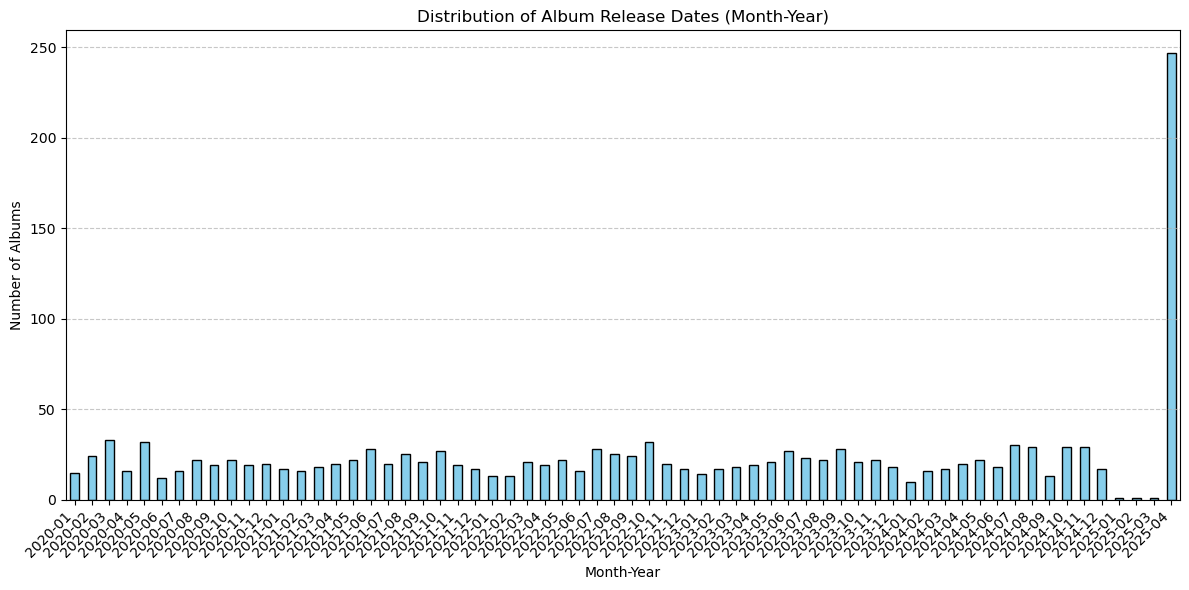

In [10]:
# Plot distribution of album release months and years
plt.figure(figsize=(12, 6))
df['release_month_year'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Album Release Dates (Month-Year)')
plt.xlabel('Month-Year')
plt.ylabel('Number of Albums')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

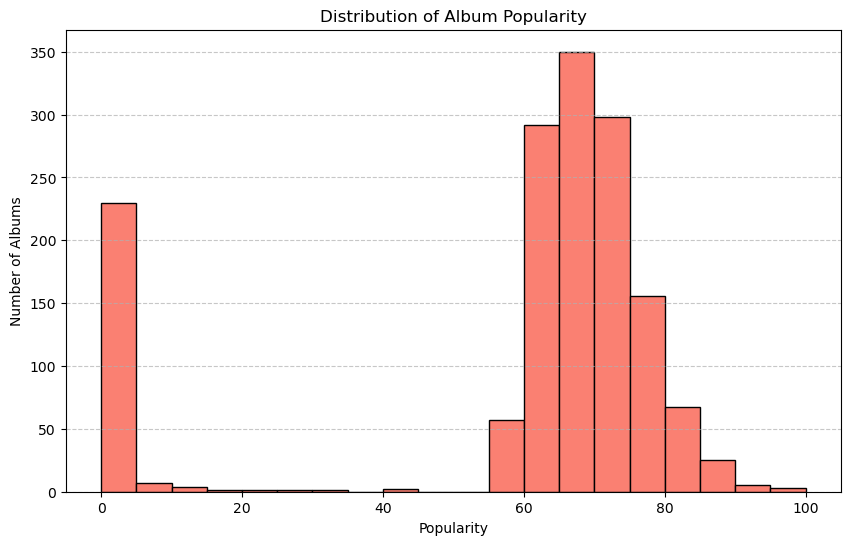

In [8]:
# Plot distribution of album popularity
plt.figure(figsize=(10, 6))
plt.hist(df['popularity'], bins=20, edgecolor='black', color='salmon')
plt.title('Distribution of Album Popularity')
plt.xlabel('Popularity')
plt.ylabel('Number of Albums')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
import pandas as pd
import requests
import time

# === CONFIGURATION ===
# api key 
API_KEY = '[api key]' 
# album csv file 
INPUT_CSV = 'recent_albums_last_5_years.csv'    
# csv file with genres 
OUTPUT_CSV = 'albums_with_genres.csv'

API_URL = 'http://ws.audioscrobbler.com/2.0/'


In [10]:
def get_album_genre(album, artist):
    params = {
        'method': 'album.getInfo',
        'api_key': API_KEY,
        'artist': artist,
        'album': album,
        'format': 'json'
    }

    try:
        time.sleep(0.25)
        response = requests.get(API_URL, params=params)
        data = response.json()

        print(f"\n=== Raw response for '{album}' by '{artist}' ===")
        print(response.text)
        print("===")

        # Check for API error
        if 'error' in data:
            print(f"⚠️ API Error: {data.get('message')}")
            return fallback_artist_genre(artist)

        # Get tags safely
        tags_section = data.get('album', {}).get('tags', {})
        if isinstance(tags_section, dict):
            tags = tags_section.get('tag', [])
            if tags:
                return tags[0]['name']
            else:
                return fallback_artist_genre(artist)
        else:
            print("⚠️ 'tags' was not a dictionary — skipping to fallback")
            return fallback_artist_genre(artist)

    except Exception as e:
        print(f"Unexpected error: {e}")
        return fallback_artist_genre(artist)

def fallback_artist_genre(artist):
    print(f"↪️ Falling back to artist-level tags for '{artist}'...")
    params = {
        'method': 'artist.getTopTags',
        'artist': artist,
        'api_key': API_KEY,
        'format': 'json'
    }

    try:
        time.sleep(0.25)
        response = requests.get(API_URL, params=params)
        data = response.json()

        tags = data.get('toptags', {}).get('tag', [])
        if tags:
            return tags[0]['name']
        else:
            return 'Unknown'
    except Exception as e:
        print(f"Fallback failed: {e}")
        return 'Error'


get_album_genre('Best White Noise For Sleeping Baby', 'Dream Supplier')




=== Raw response for 'Best White Noise For Sleeping Baby' by 'Dream Supplier' ===
{"album":{"artist":"Dream Supplier","listeners":"10246","image":[{"size":"small","#text":""},{"size":"medium","#text":""},{"size":"large","#text":""},{"size":"extralarge","#text":""},{"size":"mega","#text":""},{"size":"","#text":""}],"mbid":"","tags":"","name":"Best White Noise For Sleeping Baby","playcount":"5417126","url":"https:\/\/www.last.fm\/music\/Dream+Supplier\/Best+White+Noise+For+Sleeping+Baby"}}
===
⚠️ 'tags' was not a dictionary — skipping to fallback
↪️ Falling back to artist-level tags for 'Dream Supplier'...


'ambient'

In [12]:
import pandas as pd
import requests
import time

# === Album Genre Lookup with Fallback ===
def get_album_genre(album, artist):
    params = {
        'method': 'album.getInfo',
        'api_key': API_KEY,
        'artist': artist,
        'album': album,
        'format': 'json'
    }

    try:
        time.sleep(0.25)
        response = requests.get(API_URL, params=params)
        data = response.json()

        # Check for API error
        if 'error' in data:
            print(f"⚠️ API Error for album '{album}' by '{artist}': {data.get('message')}")
            return fallback_artist_genre(artist)

        # Handle tags
        tags_section = data.get('album', {}).get('tags', {})
        if isinstance(tags_section, dict):
            tags = tags_section.get('tag', [])
            if tags:
                genre = tags[0]['name']
                print(f"🎵 Album genre for '{album}' by '{artist}': {genre}")
                return genre
            else:
                print(f" No album tags found for '{album}' by '{artist}' — falling back.")
                return fallback_artist_genre(artist)
        else:
            print(f" 'tags' not in expected format for '{album}' by '{artist}' — falling back.")
            return fallback_artist_genre(artist)

    except Exception as e:
        print(f"Error for album '{album}' by '{artist}': {e}")
        return fallback_artist_genre(artist)

# === Artist Fallback ===
def fallback_artist_genre(artist):
    params = {
        'method': 'artist.getTopTags',
        'artist': artist,
        'api_key': API_KEY,
        'format': 'json'
    }

    try:
        time.sleep(0.25)
        response = requests.get(API_URL, params=params)
        data = response.json()

        tags = data.get('toptags', {}).get('tag', [])
        if tags:
            genre = tags[0]['name']
            print(f"🎵 Fallback artist genre for '{artist}': {genre}")
            return genre
        else:
            print(f"No artist tags found for '{artist}'.")
            return 'Unknown'

    except Exception as e:
        print(f"Fallback error for artist '{artist}': {e}")
        return 'Error'

# === Main Processing ===
print("Reading album CSV...")
df = pd.read_csv(INPUT_CSV)

print("Fetching genres from Last.fm...")
df['genre'] = df.apply(lambda row: get_album_genre(row['album_name'], row['artist_name']), axis=1)

print(f"Saving results to '{OUTPUT_CSV}'...")
df.to_csv(OUTPUT_CSV, index=False)
print("Done!")



Reading album CSV...
Fetching genres from Last.fm...
 'tags' not in expected format for 'Best White Noise For Sleeping Baby' by 'Dream Supplier' — falling back.
🎵 Fallback artist genre for 'Dream Supplier': ambient
🎵 Album genre for 'folklore' by 'Taylor Swift': folk
🎵 Album genre for 'Starting Over' by 'Chris Stapleton': country
🎵 Album genre for 'Legends Never Die' by 'Juice WRLD': juice wrld
🎵 Album genre for 'Whole Lotta Red' by 'Playboi Carti': trap
🎵 Album genre for 'After Hours' by 'The Weeknd': synthpop
🎵 Album genre for 'songs' by 'Adrianne Lenker': 2020
🎵 Album genre for 'SAVAGE MODE II' by '21 Savage': trap
🎵 Album genre for 'Welcome to O'Block' by 'King Von': gangsta rap
🎵 Album genre for 'The Lo-Fis' by 'Steve Lacy': steve lacy
🎵 Album genre for 'Kid Krow' by 'Conan Gray': pop
🎵 Album genre for 'YHLQMDLG' by 'Bad Bunny': trap
🎵 Album genre for 'THE GOAT' by 'Polo G': polo g
🎵 Album genre for 'Dark Lane Demo Tapes' by 'Drake': 2020
🎵 Album genre for 'Fuck The World' by 'Bre

In [17]:
import matplotlib.pyplot as plt
#  Read the data from the CSV file
df = pd.read_csv('albums_with_genres.csv')
# Count genres
genre_counts = df['genre'].value_counts()

# Print list of genres and counts
print("Genre Frequency List:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")



Genre Frequency List:
country: 122
rap: 97
pop: 73
Unknown: 64
2023: 58
indie: 58
2022: 45
2024: 43
rnb: 39
Hip-Hop: 32
2020: 32
trap: 28
electronic: 26
folk: 23
ambient: 22
mexico: 22
hip-hop: 21
2021: 19
rock: 18
Reggaeton: 14
reggaeton: 14
indie pop: 14
seen live: 13
k-pop: 12
christian: 12
latin: 11
Corridos tumbados: 11
metalcore: 10
soul: 10
Soundtrack: 9
jazz: 9
House: 9
puerto rico: 9
alternative rnb: 9
indie rock: 9
synthpop: 8
southern hip hop: 7
black metal: 7
my top songs: 6
rage: 6
Sleep: 6
kpop: 6
hip hop: 5
cloud rap: 5
nature sounds: 5
russian: 5
corridos tumbados: 5
alternative: 4
samba: 4
brazil: 4
gospel: 4
nigeria: 4
drill: 4
chillout: 4
pop rap: 4
phonk: 4
psychedelic: 4
dream pop: 4
soundtrack: 4
dance: 4
midnights: 3
florida: 3
reggae: 3
pop smoke: 3
funk: 3
experimental: 3
instrumental: 3
argentina: 3
australian: 3
soft rock: 3
noise: 3
progressive metal: 3
german: 3
trance: 3
shoegaze: 3
post-rock: 3
dancehall: 3
country pop: 3
aoty: 3
pop rock: 3
indietronica:

In [18]:
import pandas as pd
import requests
import time
import re
import random

# === CONFIG ===
API_URL = 'http://ws.audioscrobbler.com/2.0/'
INPUT_FILE = 'albums_with_genres.csv'
OUTPUT_FILE = 'albums_genres_cleaned.csv'

# === Function to get genre from artist only ===
def get_artist_genre(artist, retries=3):
    params = {
        'method': 'artist.getTopTags',
        'artist': artist,
        'api_key': API_KEY,
        'format': 'json'
    }

    for attempt in range(retries):
        try:
            time.sleep(random.uniform(0.45, 0.65))  # rate limits
            response = requests.get(API_URL, params=params)
            if response.status_code != 200:
                continue
            data = response.json()

            tags = data.get('toptags', {}).get('tag', [])
            if tags:
                # Return first non-numeric tag
                for tag in tags:
                    name = tag.get('name', '').strip().lower()
                    if not re.fullmatch(r'\d{4}', name):  # ignore year-like tags
                        return name
            return 'Unknown'
        except Exception as e:
            print(f"Error for artist '{artist}' on attempt {attempt + 1}: {e}")
            time.sleep(1 + attempt)
    return 'Error'

# === Load original dataset ===
df = pd.read_csv(INPUT_FILE)

# === Identify rows with year-like genre tags ===
def is_year_tag(tag):
    return bool(re.fullmatch(r'\d{4}', str(tag).strip()))

needs_fix = df[df['genre'].apply(is_year_tag)].copy()
print(f"🔍 Found {len(needs_fix)} albums with year-style genre tags")

# === Re-fetch genres using artist fallback ===
fixed_genres = []
for index, row in needs_fix.iterrows():
    artist = row['artist_name']
    new_genre = get_artist_genre(artist)
    print(f"🎵 {row['album_name']} by {artist} → {new_genre}")
    fixed_genres.append(new_genre)

# Add corrected genres
needs_fix['genre'] = fixed_genres

# === Merge back into original dataset ===
df_cleaned = df.copy()
df_cleaned.update(needs_fix)

# === Save final cleaned dataset ===
df_cleaned.to_csv(OUTPUT_FILE, index=False)
print(f"Cleaned file saved to '{OUTPUT_FILE}'")


🔍 Found 199 albums with year-style genre tags
🎵 songs by Adrianne Lenker → singer-songwriter
🎵 Dark Lane Demo Tapes by Drake → hip-hop
🎵 Levon James by King Von → drill
🎵 Circles by Mac Miller → hip-hop
🎵 WUNNA by Gunna → rap
🎵 Music To Be Murdered By by Eminem → rap
🎵 High Off Life by Future → hip-hop
🎵 Heaven & Hell by Ava Max → pop
🎵 Eternal Atake (Deluxe) - LUV vs. The World 2 by Lil Uzi Vert → trap
🎵 What Could Possibly Go Wrong by Dominic Fike → indie
🎵 Good News by Megan Thee Stallion → rap
🎵 Chip Chrome & The Mono-Tones by The Neighbourhood → indie
🎵 THE END OF EVERYTHING by Noah Cyrus → pop
🎵 Sellout by Koe Wetzel → country
🎵 I Let It in and It Took Everything by Loathe → metalcore
🎵 Pegasus by Trippie Redd → trap
🎵 Born Here Live Here Die Here by Luke Bryan → country
🎵 Texas Sun by Khruangbin → funk
🎵 It Was Good Until It Wasn't by Kehlani → rnb
🎵 Alfredo by Freddie Gibbs → hip-hop
🎵 Fallin' by StaySolidRocky → hip-hop
🎵 Sweet Action by Jack Harlow → rap
🎵 F8 by Five Finger D

In [19]:
#  Read the data from the CSV file
df = pd.read_csv('albums_genres_cleaned.csv')
# Count genres
genre_counts = df['genre'].value_counts()

# Print list of genres and counts
print("Genre Frequency List:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

Genre Frequency List:
country: 139
rap: 120
pop: 101
indie: 68
Unknown: 64
rnb: 53
hip-hop: 48
trap: 36
electronic: 32
Hip-Hop: 32
seen live: 25
mexico: 24
folk: 23
rock: 23
ambient: 22
reggaeton: 18
k-pop: 17
indie pop: 16
Reggaeton: 14
soul: 14
jazz: 13
christian: 12
metalcore: 12
latin: 11
Corridos tumbados: 11
Soundtrack: 9
House: 9
alternative rnb: 9
puerto rico: 9
indie rock: 9
synthpop: 8
black metal: 7
southern hip hop: 7
dream pop: 7
my top songs: 6
rage: 6
kpop: 6
Sleep: 6
drill: 6
soundtrack: 5
alternative: 5
corridos tumbados: 5
russian: 5
nature sounds: 5
funk: 5
hip hop: 5
cloud rap: 5
chillout: 4
gospel: 4
progressive metal: 4
pop rap: 4
dance: 4
female vocalists: 4
psychedelic: 4
brazil: 4
nigeria: 4
hyperpop: 4
samba: 4
trance: 4
phonk: 4
german: 3
soft rock: 3
singer-songwriter: 3
australian: 3
midnights: 3
dancehall: 3
bedroom pop: 3
Progressive metal: 3
acoustic: 3
instrumental: 3
pop smoke: 3
noise: 3
reggae: 3
argentina: 3
florida: 3
house: 3
pop rock: 3
shoegaze: